In [0]:
%tensorflow_version 1.x
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [0]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [37]:

filelist_trainx = sorted(glob.glob('/content/drive/My Drive/input/dgu_trainx/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

# for i in range(len(filelist_trainx)):
# X_train = np.array([np.array(Image.open(fname)) for fname])

filelist_trainy_in = sorted(glob.glob('/content/drive/My Drive/input/dgu_trainy_in/*.jpg'), key=numericalSort)
filelist_trainy_out = sorted(glob.glob('/content/drive/My Drive/input/dgu_trainx_eq/*.jpg'), key=numericalSort)
Y_train_in = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_in])
Y_train_out = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_out])
print(len(filelist_trainx))
print(len(filelist_trainy_in))
print(len(filelist_trainy_out))

40
40
40


In [38]:
print(X_train[0].shape)
print(Y_train_in[0].shape)
print(Y_train_out[0].shape)

(700, 1440, 3)
(700, 1440, 3)
(700, 1440)


In [0]:
def resizeX(filename, size = (224,224)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)

def resizeY(filename, size = (224,224)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS).convert('1')
    return (im_resized)
    


    # im = Image.open(filename)
    # ret, im_resized = cv2.threshold(img,127,255, cv2.THRESH_BINARY)
    # cv2.resize(im_resized, size)
    # im_resized = im.resize(size, Image.ANTIALIAS)
    # ret, im_resized = cv2.threshold(im_resized, 127, 255, cv2.THRESH_BINARY)
#   im_resized.save('/resized_ph2/X_train/X_img_'+str(i)+'.bmp', dpi = (192,256))

In [0]:
X_train_ph2_resized = []
Y_train_ph2_resized_in = []
Y_train_ph2_resized_out = []
Y_train_in_non_binaried = []
Y_train_out_non_binaried = []
Z_train_in = []
Z_train_out = []

for i in range(len(filelist_trainx)):
    X_train_ph2_resized.append(resizeX(filelist_trainx[i]))
    Y_train_ph2_resized_in.append(resizeY(filelist_trainy_in[i])) 
    Y_train_ph2_resized_out.append(resizeY(filelist_trainy_out[i])) 
    Y_train_in_non_binaried.append(resizeX(filelist_trainy_in[i]))
    Y_train_out_non_binaried.append(resizeX(filelist_trainy_out[i]))

In [0]:
del(X_train)
del(Y_train_in)
del(Y_train_out)
del(Z_train_in)
del(Z_train_out)

X_train = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train_in = np.array([np.array(img) for img in Y_train_ph2_resized_in])
Y_train_out = np.array([np.array(img) for img in Y_train_ph2_resized_out])
Z_train_in = np.array([np.array(img) for img in Y_train_in_non_binaried])
Z_train_out = np.array([np.array(img) for img in Y_train_out_non_binaried])

(224, 224, 3)
(224, 224)
(224, 224)


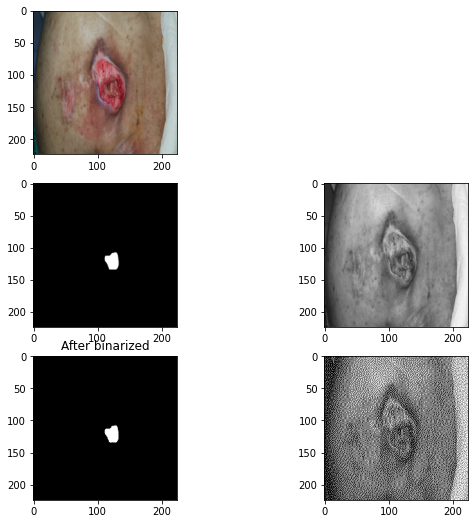

In [42]:
print(X_train[0].shape)
print(Y_train_in[0].shape)
print(Y_train_out[0].shape)

# cnt = 0
# for i in range(224):
#   for j in range(224):
#     if Y_train[0][i][j] != Z_train[0][i][j]:
#       print('Y : ' + str(Y_train[0][i][j]) + ' Z : ' + str(Z_train[0][i][j]))
# print(cnt)
# print(len(Y_train))

plt.figure(figsize=(20,9))
plt.subplot(3,4,1)
plt.imshow(X_train[0])
plt.subplot(3,4,5)
plt.imshow(Z_train_in[0], plt.cm.binary_r)
plt.subplot(3,4,6)
plt.imshow(Z_train_out[0], plt.cm.binary_r)
plt.subplot(3,4,9)
plt.title('After binarized')
plt.imshow(Y_train_in[0], plt.cm.binary_r)
plt.subplot(3,4,10)
plt.imshow(Y_train_out[0], plt.cm.binary_r)

In [0]:
x_train_in, x_test_in, y_train_in, y_test_in = train_test_split(X_train, Y_train_in, test_size = 0.25, random_state = 101)

In [0]:
x_train_out, x_test_out, y_train_out, y_test_out = train_test_split(X_train, Y_train_out, test_size = 0.25, random_state = 101)

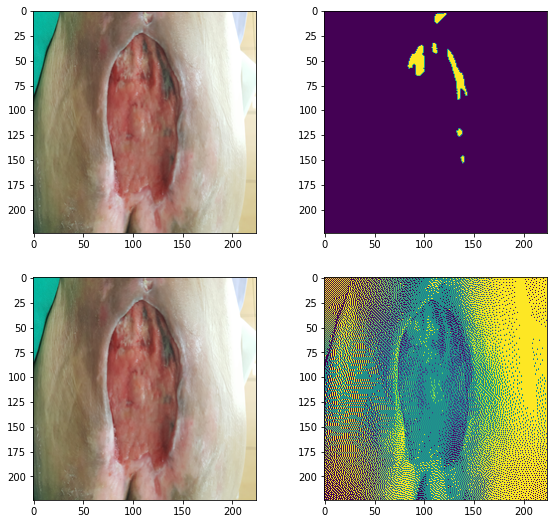

In [45]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(x_train_in[1])
plt.subplot(2,4,2)
plt.imshow(y_train_in[1])
plt.subplot(2,4,5)
plt.imshow(x_train_out[1])
plt.subplot(2,4,6)
plt.imshow(y_train_out[1])
plt.show()

In [0]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [0]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [0]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [0]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [0]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [0]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [0]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [0]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [0]:
x_rotated_in, y_rotated_in, x_flipped_in, y_flipped_in = img_augmentation(x_train_in, y_train_in)

In [0]:
x_rotated_out, y_rotated_out, x_flipped_out, y_flipped_out = img_augmentation(x_train_out, y_train_out)

In [0]:
x_train_full_in = np.concatenate([x_train_in, x_rotated_in, x_flipped_in])
y_train_full_in = np.concatenate([y_train_in, y_rotated_in, y_flipped_in])
x_train_full_out = np.concatenate([x_train_out, x_rotated_out, x_flipped_out])
y_train_full_out = np.concatenate([y_train_out, y_rotated_out, y_flipped_out])

In [0]:
x_train_in, x_val_in, y_train_in, y_val_in = train_test_split(x_train_full_in, y_train_full_in, test_size = 0.20, random_state = 101)
x_train_out, x_val_out, y_train_out, y_val_out = train_test_split(x_train_full_out, y_train_full_out, test_size = 0.20, random_state = 101)

In [61]:
print(x_train_in[0].shape)
print(y_train_in[0].shape)

(224, 224, 3)
(224, 224)


In [62]:
print("Length of the Training Set   : {}".format(len(x_train_in)))
print("Length of the Test Set       : {}".format(len(x_test_in)))
print("Length of the Validation Set : {}".format(len(x_val_in)))

Length of the Training Set   : 144
Length of the Test Set       : 10
Length of the Validation Set : 36


In [0]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [0]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.common.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename, x_train, y_train, x_val, y_val):
    dropout_val=0.50
    if K.common.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 3,validation_data=(x_val, y_val), verbose=1)
    model.save(savename)
    return model, hist

In [66]:
model_in, hist_in = UNET_224(1, 'dgu_unet_1_epoch_in.h5', x_train_in, y_train_in, x_val_in, y_val_in)
model_out, hist_out = UNET_224(1, 'dgu_unet_1_epoch_out.h5', x_train_out, y_train_out, x_val_out, y_val_out)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "UNET_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
_________

In [0]:
dropout_val=0.50
if K.common.image_dim_ordering() == 'th':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((224,224))(conv_final)

In [0]:
model_0 = Model(inputs, pred, name="UNET_224")
model_0.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])

In [0]:
model_0.load_weights('dgu_unet_1_epoch_in.h5')

In [70]:

print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train_in, y_train_in, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test_in, y_test_in, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}i  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val_in, y_val_in, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

144/144 [==============================] - 6s 43ms/step
________________________
IOU:       |   31.89  |
Dice Coef: |   2.93  |
Precision: |   1.49  |
Recall:    |   100.00  |
Accuracy:  |   1.49  |
Loss:      |   68.11  |
________________________

-------------On Test  Set--------------------------

10/10 [==============================] - 2s 191ms/step
________________________
IOU:       |   32.19  |
Dice Coef: |   3.77  |
Precision: |   1.91i  |
Recall:    |   100.00  |
Accuracy:  |   1.91  |
Loss:      |   67.81  |
________________________

-------------On validation Set---------------------

36/36 [==============================] - 1s 20ms/step
________________________
IOU:       |   32.31  |
Dice Coef: |   4.11  |
Precision: |   2.09  |
Recall:    |   100.00  |
Accuracy:  |   2.09  |
Loss:      |   67.69  |
________________________


In [0]:
model_0.load_weights('dgu_unet_1_epoch_out.h5')

In [72]:
print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train_out, y_train_out, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test_out, y_test_out, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}i  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val_out, y_val_out, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

144/144 [==============================] - 3s 20ms/step
________________________
IOU:       |   48.43  |
Dice Coef: |   40.11  |
Precision: |   25.41  |
Recall:    |   100.00  |
Accuracy:  |   25.41  |
Loss:      |   51.57  |
________________________

-------------On Test  Set--------------------------

10/10 [==============================] - 0s 21ms/step
________________________
IOU:       |   71.26  |
Dice Coef: |   73.77  |
Precision: |   58.43i  |
Recall:    |   100.00  |
Accuracy:  |   58.43  |
Loss:      |   28.74  |
________________________

-------------On validation Set---------------------

36/36 [==============================] - 1s 20ms/step
________________________
IOU:       |   43.73  |
Dice Coef: |   31.37  |
Precision: |   18.60  |
Recall:    |   100.00  |
Accuracy:  |   18.60  |
Loss:      |   56.27  |
________________________


In [0]:
model_in, hist_in = UNET_224(100, '/content/drive/My Drive/models/dgu_unet_100_epoch_inEQ.h5', x_train_in, y_train_in, x_val_in, y_val_in)
model_out, hist_out = UNET_224(100, '/content/drive/My Drive/models/dgu_unet_100_epoch_outEQ.h5', x_train_out, y_train_out, x_val_out, y_val_out)

Model: "UNET_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 224, 224, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 224, 224, 32) 128         conv2d_70[0][0]                  
__________________________________________________________________________________________________
activation_70 (Activation)      (None, 224, 224, 32) 0           batch_normalization_67[0][0]     
___________________________________________________________________________________________

In [0]:
model_1 = Model(inputs, pred, name="UNET_224")
model_1.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])

In [0]:
model_1.load_weights('/content/drive/My Drive/models/dgu_unet_100_epoch_inEQ.h5')

In [0]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train_in, y_train_out, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test_in, y_test_in, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val_in, y_val_in, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

In [0]:
model_1.load_weights('/content/drive/My Drive/models/dgu_unet_100_epoch_outEQ.h5')

print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train_out, y_train_out, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test_out, y_test_out, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val_out, y_val_out, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

In [0]:
def enhance_in(img):
    model_1.load_weights('/content/drive/My Drive/models/dgu_unet_100_epoch_inEQ.h5')
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()
    # sub = Image.fromarray(sub)
    # sub = sub.convert('L')
    # sub2 = sub.resize((224,224), Image.ANTIALIAS).convert('L')
    # ret, th = cv2.threshold(sub,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    for i in range(len(sub)):
        if sub[i] > 0.0015:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

def enhance_out(img):
    model_1.load_weights('/content/drive/My Drive/models/dgu_unet_100_epoch_outEQ.h5')
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()
    # enhanceImg = cv2.threshold(sub,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    for i in range(len(sub)):
        if sub[i] > 0.0015:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

In [0]:
plt.suptitle('Comparing the Prediction after enhancement')
for i in range(len(x_test_in)):
  plt.figure(figsize=(12,12))
  plt.subplot(5,3,1 + i*3)
  plt.title('Origin Image')
  plt.imshow(x_test_in[i],plt.cm.binary_r)
  plt.subplot(5,3,2 + i*3)
  plt.title('Ground Truth_in')
  plt.imshow(y_test_in[i],plt.cm.binary_r)
  plt.subplot(5,3,3 + i*3)
  plt.title('Predicted_in')
  plt.imshow(enhance_in(x_test_in[i]).reshape(224,224), plt.cm.binary_r)
  plt.subplot(5,3,4 + i*3)
  plt.title('Ground_Truth_out')
  plt.imshow(y_test_out[i],plt.cm.binary_r)
  plt.subplot(5,3,5 + i*3)
  plt.title('Predicted_out')
  plt.imshow(enhance_out(x_test_out[i]).reshape(224,224),plt.cm.binary_r)
  plt.show()

In [0]:
for i in range(len(x_test_out)):
  plt.figure(figsize=(8,8))
  plt.subplot(2,2,1)
  plt.title('Origin Image')
  plt.imshow(x_test_out[i],plt.cm.binary)
  plt.subplot(2,2,2)
  plt.title('Ground_Truth_out')
  plt.imshow(y_test_out[i],plt.cm.binary_r)
  plt.subplot(2,2,3)
  plt.title('Predicted_out')
  plt.imshow(enhance_out(x_test_out[i]).reshape(224,224),plt.cm.binary_r)
  # plt.savefig('/content/drive/My Drive/results/dgu_improved_100epoch_3batch/results/' + str(i) + '.jpg')

In [0]:
for i in range(len(X_train)):
  plt.figure(figsize=(8,12))
  plt.subplot(3,2,1)
  plt.title('Origin Image')
  plt.imshow(X_train[i])
  plt.subplot(3,2,3)
  plt.title('Ground Truth_in')
  plt.imshow(Y_train_in[i],plt.cm.binary_r)
  plt.subplot(3,2,4)
  plt.title('Predicted_in')
  plt.imshow(enhance_in(X_train[i]).reshape(224,224), plt.cm.binary_r)
  plt.subplot(3,2,5)
  plt.title('Ground_Truth_out')
  plt.imshow(Y_train_out[i],plt.cm.binary_r)
  plt.subplot(3,2,6)
  plt.title('Predicted_out')
  plt.imshow(enhance_out(X_train[i]).reshape(224,224),plt.cm.binary_r)
  plt.savefig('/content/drive/My Drive/results/dgu_improved_100epoch_3batch/results/' + str(i) + '.jpg')

  # model_1.load_weights('dgu_unet_100_epoch_in.h5')
  # predictions_in =model_1.predict(x_train_full_in[i].reshape(1,224,224,3))
  # model_1.load_weights('dgu_unet_100_epoch_out.h5')
  # predictions_out = model_1.predict(x_train_full_out[i].reshape(1,224,224,3))
  # prediction_in = predictions_in.reshape(224, 224)
  # prediction_out = predictions_out.reshape(224,224)
  # plt.imsave('/content/drive/My Drive/results/dgu_improved_100epoch_3batch/result_x/' + str(i) + '_x.jpg', x_train_full[i])
  # plt.imsave('/content/drive/My Drive/results/dgu_improved_100epoch_3batch/result_y/' + str(i) + '_y.jpg', y_train_full[i])
  # plt.imsave('/content/drive/My Drive/results/dgu_improved_100epoch_3batch/results/' + str(i) + '.jpg', prediction)